In [28]:
import sqlite3
import pandas as pd
import nltk
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    PER,
    NamesExtractor,
    Doc
)
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN


import matplotlib.pyplot as plt


In [8]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
morph_analyzer = MorphAnalyzer()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])
stop_words = set(nltk.corpus.stopwords.words('russian'))
stop_symb = set(['.', ' '])

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     C:\Users\R E K L\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\R E K
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\R E K
[nltk_data]     L\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
con = sqlite3.connect('../NLP 1/snatcher/db/nta.db')
df = pd.read_sql_query('SELECT * FROM nta', con)
con.close()
df.head()

,title,content,category,created_date
0,Глеб Никитин и Михаил Мурашко открыли в Нижнем...,Нижний Новгород. 2 января. НТА-Приволжье —Губе...,Общество,2023-01-02
1,Движение возле нижегородского Дворца спорта ог...,Нижний Новгород. 2 января. НТА-Приволжье — Дви...,Городское хозяйство; ЖКХ,2023-01-02
2,Еще один случай нападения на сотрудника скорой...,Саратов. 1 января. НТА-Приволжье — Еще один сл...,Происшествия и криминал,2023-01-01
3,Пожар в доме на улице Бориса Панина тушили 2 я...,Нижний Новгород. 2 января. НТА-Приволжье — Пож...,Происшествия и криминал,2023-01-02
4,"Спектакль ""Человеку нужен человек"" по пьесе Не...",Нижний Новгород. 2 января. НТА-Приволжье — В Н...,Культура и искусство,2023-01-02


In [9]:
data = df.content.apply(lambda x: x.split('. '))
data

0      [Нижний Новгород, 2 января, НТА-Приволжье —Губ...
1      [Нижний Новгород, 2 января, НТА-Приволжье — Дв...
2      [Саратов, 1 января, НТА-Приволжье — Еще один с...
3      [Нижний Новгород, 2 января, НТА-Приволжье — По...
4      [Нижний Новгород, 2 января, НТА-Приволжье — В ...
                             ...                        
135    [Нижний Новгород, 5 января, НТА-Приволжье - Мо...
136    [Чебоксары, 5 января, НТА-Приволжье – Восемь д...
137    [Чебоксары, 5 января, НТА-Приволжье – Житель Ч...
138    [Нижний Новгород, 5 января, НТА-Приволжье - Бо...
139    [Чебоксары, 5 января, НТА-Приволжье – СУСК по ...
Name: content, Length: 140, dtype: object

# Нормализация

In [11]:
def normalize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    normalized_tokens = []
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        if token.lemma not in stop_words and token.lemma not in stop_symb:
            normalized_tokens.append(token.lemma)
    return ' '.join(normalized_tokens)

In [15]:
normis = []
for i in range(len(data)):
    normis.append([normalize_text(sent) for sent in data[i]])
normis[1]

['нижний новгород',
 '2 январь',
 'нта-приволжье — движение возле нижегородский дворец спорт ограничить новогодний праздник',
 'сообщить городской дептранс , ограничение действовать 3 6 январь 07 : 00 20 : 00',
 'объезд возможный прилегать участок улично-дорожный сеть',
 'автомобилист просить учитывать данный информация планирование поездка',
 ', движение транспорт закрыть улица барнаульский конец февраль 2023 год']

# Векторизация

In [23]:
vectors = []
vectorizer = CountVectorizer()
for text in normis:
    if len(text) < 2:
        continue
    X = vectorizer.fit_transform(text)
    vectors.append(X)

# Сжатие

In [26]:
compress = []
for X in vectors:
    pca = PCA(n_components=2)
    compress.append(pca.fit_transform(X.toarray()))

# Клатеризация

In [30]:
cluster = []
for x_pca in compress:
    dbscan = DBSCAN(eps=0.5, min_samples=2)
    cluster.append(dbscan.fit_predict(x_pca))

# Визуализация

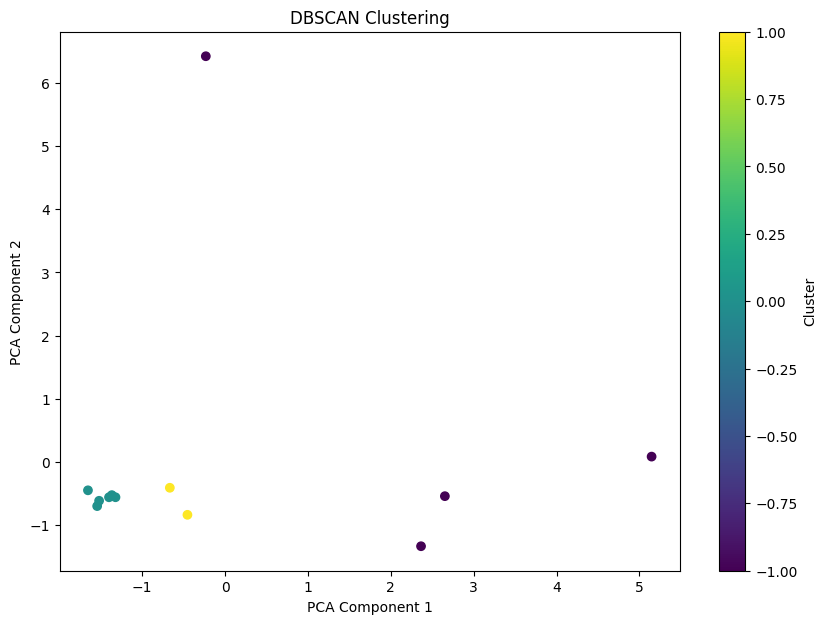

4
Cluster 0:
['Нижний Новгород', '2 января', 'Начало спектаклей в 14:00 и 18:00', 'В рамках этого проекта сотрудники театра провели творческий конкурс "Коробка"', 'Общность проблем и вопросов, волнующих детей-сирот, позволила объединить их истории в одном спектакле, который поставил режиссер Владимир Червяков."Для меня самое главное, что этот спектакль состоялся', 'Получилась очень душевная, честная и искренняя постановка']
Cluster 1:
['Человеку нужен человек"', 'Ее действующими лицами стали дети из детских домов и люди, встречи с которыми им запомнились, оказались важными и определяющими в их жизни']
Cluster -1:
['НТА-Приволжье — В Нижегородском государственном театре юного зрителя 14 января 2023 года пройдут показы спектакля "Человеку нужен человек" по пьесе нижегородской журналистки и драматурга Неллы Прибутковской.Сюжет пьесы выстроен на основе реальных историй воспитанников детских домов и школ-интернатов региона', 'Вырученные от продажи билетов средства планируется передать благо

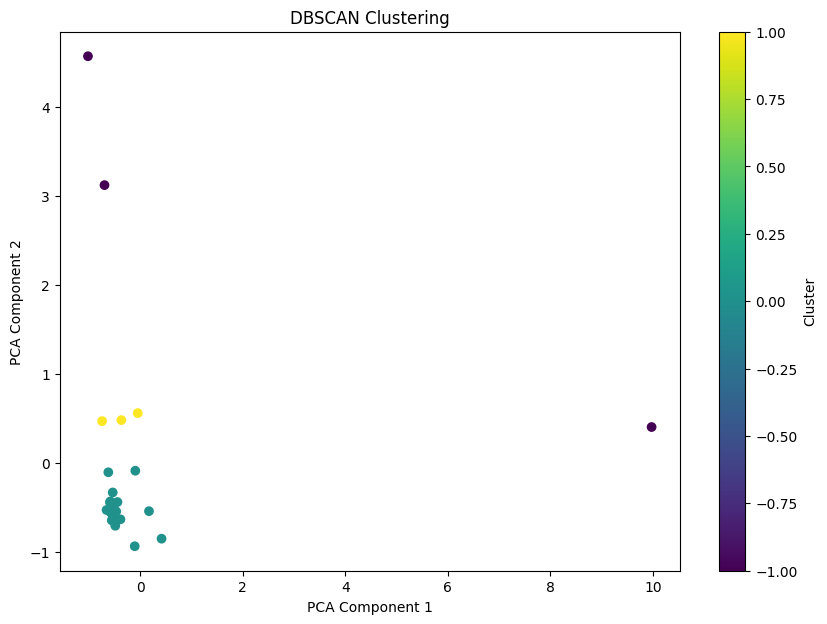

11
Cluster 0:
['Нижний Новгород', '2 января', 'НТА-Приволжье — Концепцию благоустройства сада при усадьбе М.Ф', 'Концепция благоустройства предусматривает озеленение сада кустарниками калины, гортензии и сирени, вьющимися растениями – княжиком, девичьим виноградом, клематисами, плодовыми культурами – боярышником и иргой', 'Сад уже сейчас наполнен большими деревьями – березами повислыми и липами мелколистными, кроны которых создают тень в квартале в течение всего дня', 'Учитывая световые условия территории, разработчики концепции предусмотрели высадку там тенелюбивых цветов многолетников – хоста, барвинок, астильба', 'Из хвойных деревьев в композицию сада будут добавлены несколько сербских елей или пихт, которые можно будет украшать на новогодние праздники."Все виды устойчивы к нашим погодным условиям и успешно используются при озеленении территорий', 'Кроме того, световая организация в квартале будет спланирована с учетом потребностей расположенной здесь церкви.В качестве покрытия садо

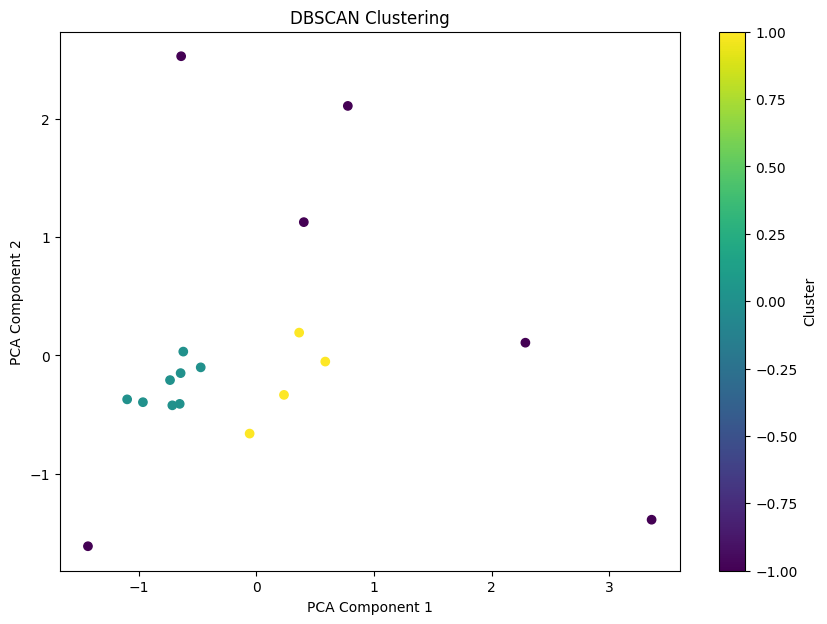

13
Cluster 0:
['Нижний Новгород', '2 января', ' Об этом в телеграм-канале сообщил глава Нижнего Новгорода Юрий Шалабаев', ' В частности, людям было предоставлено жилье в ЖК "Корабли"', 'Глава города недавно побывал у новоселов и ознакомился с условиями их проживания', 'Расселено около 1,5 тысяч человек', 'Это позволяет максимально учесть потребности расселяемых семей", - отметил Юрий Шалабаев', 'Краснодонцев в Нижнем Новгороде.']
Cluster 1:
['НТА-Приволжье — В 2022 году из ветхого аварийного жилья было расселено 1,5 тысячи человек', 'Так, в жилом доме № 60 муниципалитетом для расселения было закуплено 84 квартиры', '  В 2022 году было приобретено 400 квартир для семей', ' "Сейчас ведем строительство двух домов в Автозаводском районе, также активно закупаем квартиры у застройщиков на этапе строительства']
Cluster -1:
[' Как заявил градоначальник, для расселения в 2020 году было закуплено 38 квартир только на вторичном рынке, в 2021 году уже 90 (часть покупали на этапе строительства по д

In [38]:
for numb in [4, 11, 13]: #len(cluster)):
    df = pd.DataFrame({'x': compress[numb][:, 0], 'y': compress[numb][:, 1], 'cluster': cluster[numb]})

    plt.figure(figsize=(10, 7))
    plt.scatter(df['x'], df['y'], c=df['cluster'], cmap='viridis', marker='o')
    plt.title('DBSCAN Clustering')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

    # Выделение тем по кластерам
    print(numb)
    for clust in set(cluster[numb]):
        print(f"Cluster {clust}:")
        cluster_texts = [data[numb][i] for i in range(len(cluster[numb])) if cluster[numb][i] == clust]
        print(cluster_texts)

Текст 1:\
кластер 0: Место и Событие
кластер 1: Люди, персонажи и тд

Текс 2: \
кластер 0: Сад, растение, ботаника
кластер 1: Архитектура. Создание тропинки

Текст 3: \
кластер 0: Город и жители
кластер 1: Недвижимость (Квартиры)

ps - кластер -1 - не вошедшие в кластера
